# REI505M Machine Learning - Final project
### Due: --------

**Names**: Axel Kristján Axelsson, Bjarni Haukur Bjarnason <br />
**Email**: aka30@hi.is, bhb23@hi.is

**1. Image classification**

s


In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
import tensorflow_io as tfio
tf.executing_eagerly()


from data_loader import MyDataLoader
from neural_nets import NeuralNets
from helper_funcs import *
from my_dataset import parse_to_image, parse_and_augment

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


%load_ext autoreload 
%autoreload 2

norm = (128,128)

dl = MyDataLoader("combine3", norm)
nn = NeuralNets(norm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import math
from my_dataset import create_dataset_from_files

# filenames = dl.get_all_filenames()
# val_files = filenames[index_arr1]
# train_files = np.delete(filenames, index_arr1)
# test_files = train_files[index_arr2]
# train_files = np.delete(train_files, index_arr2)
# NUM_FILES = len(filenames)
# index_arr1 = np.random.choice(NUM_FILES, VAL_SIZE)
# index_arr2 = np.random.choice(NUM_FILES-VAL_SIZE, TEST_SIZE)

train_files = dl.numpy_load("train_files")
test_files  = dl.numpy_load("test_files")
val_files   = dl.numpy_load("val_files")

BATCH_SIZE = 64
WORKERS    = 16
TEST_SIZE  = test_files.shape[0]
VAL_SIZE   = val_files.shape[0]
TRAIN_SIZE = train_files.shape[0]
NUM_FILES  = TEST_SIZE + VAL_SIZE + TRAIN_SIZE


NUM_TRAIN_STEPS = math.floor(TRAIN_SIZE/BATCH_SIZE)
NUM_VAL_STEPS   = math.floor(VAL_SIZE/BATCH_SIZE)

ds_train = create_dataset_from_files(train_files, batch_size=BATCH_SIZE, num_parallel_calls=WORKERS, augment=True)
ds_val   = create_dataset_from_files(val_files, batch_size=BATCH_SIZE, num_parallel_calls=WORKERS, augment=True)
ds_test  = create_dataset_from_files(test_files)

In [16]:
def SSIMLoss(y_true, y_pred):
  return (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0)))#+0.5*tf.keras.metrics.mean_squared_error(y_true,y_pred)

In [17]:
model = nn.model_i()
model.compile(optimizer='rmsprop', loss=SSIMLoss, metrics=["accuracy"])
log_dir = "logs/fit/" + "model_i"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 512)       1

In [18]:
from random import randint


num_iters = 20

test_images = ds_test.as_numpy_iterator().next()


history_arr = np.ndarray(shape=(num_iters,), dtype=object)
for i in range(num_iters):
    history_arr[i] = model.fit(ds_train, epochs=5, steps_per_epoch=NUM_TRAIN_STEPS, validation_data=ds_val, validation_steps=NUM_VAL_STEPS, callbacks=[tensorboard_callback])
    
    if i%2==0:
        save_model(model, f"model_i_SSIMV2_{i}", brave=True)

    img_number = randint(0, BATCH_SIZE-1)
    img = np.expand_dims(test_images[0][img_number], 0)
    pred = model.predict(img)
    save_images(img , map_from(pred), name="model_i_SSIMV2", enumerate=i)

Epoch 1/5
451/451 [==============================] - 82s 171ms/step - loss: 0.1267 - accuracy: 0.7613 - val_loss: 0.1217 - val_accuracy: 0.7590
Epoch 2/5
451/451 [==============================] - 77s 170ms/step - loss: 0.1236 - accuracy: 0.7617 - val_loss: 0.1198 - val_accuracy: 0.7596
Epoch 3/5
451/451 [==============================] - 78s 172ms/step - loss: 0.1224 - accuracy: 0.7619 - val_loss: 0.1195 - val_accuracy: 0.7598
Epoch 4/5
451/451 [==============================] - 82s 181ms/step - loss: 0.1215 - accuracy: 0.7621 - val_loss: 0.1192 - val_accuracy: 0.7606
Epoch 5/5
451/451 [==============================] - 82s 183ms/step - loss: 0.1205 - accuracy: 0.7619 - val_loss: 0.1186 - val_accuracy: 0.7598
INFO:tensorflow:Assets written to: c:\Skoli\Haust2021\Lokaverkefni\GG-Lokaverkefni\models\model_i_SSIMV2_0\assets
Epoch 1/5
451/451 [==============================] - 80s 177ms/step - loss: 0.1197 - accuracy: 0.7620 - val_loss: 0.1170 - val_accuracy: 0.7601
Epoch 2/5
451/451 [===

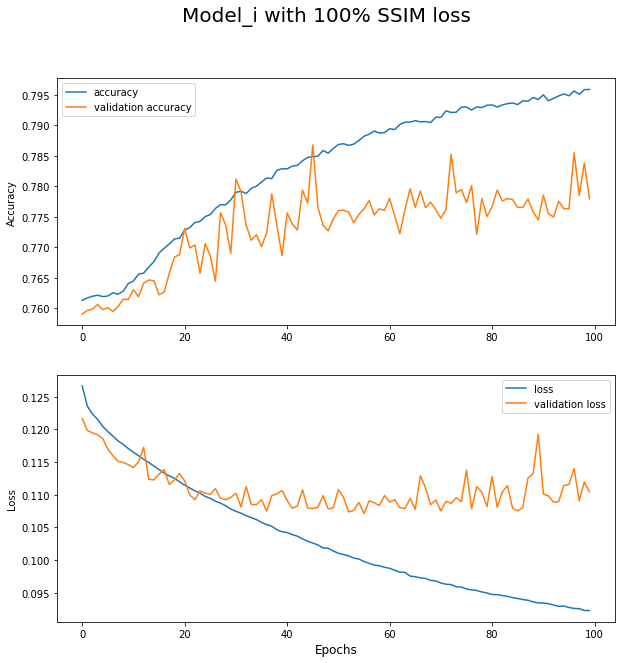

In [19]:
from matplotlib import pyplot as plt
from helper_funcs import *

# new_arr = np.ndarray(shape=(30,), dtype=object)
# new_arr[:10] = history_arr
# new_arr[10:] = history_arr2

plot_acc_and_loss(history_arr, title="Model_i with 100% SSIM loss", name="model_i_SSIMV2", save=True, figsize=(10,10))


In [41]:
model = load_model("model_i_SSIMV2_10", custom={'SSIMLoss':SSIMLoss})

In [36]:
####################################################################################
# model_e14 frekar gott general skill, model_e40 gott en of miklir litir
####################################################################################
####################################################################################
# model_i_SSIM19 er skringilega gott
####################################################################################


from skimage import color
# save_model(model, "model_e40")

# img_numbers = np.random.choice(size, 5)
# test_image = X_test[img_numbers]
iter = ds_test.as_numpy_iterator()
test_image = iter.next()

num_images = 4

grey = test_image[0][:num_images]
ab   = test_image[1][:num_images]

none_arr = np.zeros(shape=(num_images, norm[0], norm[1], 2))

pred = model.predict(grey)
show_images(grey, none_arr)
show_images(grey, map_from(pred), enhance=1.2)
show_images(grey, map_from(ab))


In [42]:
from random import randint

iter = ds_test.as_numpy_iterator()
test_image = iter.next()

num_images = 10

grey = test_image[0][:num_images]
ab   = test_image[1][:num_images]
pred = model.predict(grey)
for i in range(num_images):
    rand = randint(0, 1)
    if rand:
        show_images(grey[i:i+1], map_from(ab[i:i+1]), enhance=0.8)
    else:
        show_images(grey[i:i+1], map_from(pred[i:i+1]), enhance=1.2)
    print(rand)

0
0
1
0
1
0
0
1
1
1


In [49]:
from gan import MyGAN

gan = MyGan(ds_train, ds_val, )

[5, 8]
